## 0. Import relevant libraries

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import random as rd
import pickle

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import splrep, BSpline
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from csaps import csaps

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## 1. Import features data

In [2]:
" Import data as Python pandas DataFrame "

_ADSORBATE_ = 'N2'

LOC_STR = "/Users/arijitchakraborty/Library/CloudStorage/GoogleDrive-ac4758@columbia.edu/My Drive/Research/7_Zeolite_wTAMU_CES/Data/complete_data_avail.xlsx"
_DATA_ = pd.read_excel(LOC_STR, sheet_name=0, header=0, index_col='name')
            
_DATA = _DATA_[['density', 'spg', 'volume', 'pld', 'lcd', 'void_frac', 'surf_area_m2g',
       'surf_area_m2cm3', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere',
       'largest_included_sphere', 'largest_included_sphere_free']]


## 2. Import output variables' data

In [3]:
ADSORBATE_LOC_STR = "/Users/arijitchakraborty/Library/CloudStorage/GoogleDrive-ac4758@columbia.edu/My Drive/Research/7_Zeolite_wTAMU_CES/Data/"+ _ADSORBATE_ + ".xlsx"

ADSORBATE_xl = pd.ExcelFile(ADSORBATE_LOC_STR)
len(ADSORBATE_xl.sheet_names)  # sheet names


197

## 3. Obtain common adsorbents

In [4]:
_COMMON_ADSORBENTS = list(set(ADSORBATE_xl.sheet_names).intersection(_DATA.index))
print('There are ' + str(len(_COMMON_ADSORBENTS)) + ' common adsorbents.')


There are 190 common adsorbents.


### 3.1 Reindex based on common adsorbents

In [5]:
_DATA_REINDEXED = _DATA.reindex(_COMMON_ADSORBENTS)

print('Shape of the inputs is: ', _DATA_REINDEXED.shape)


Shape of the inputs is:  (190, 16)


## Load the data

Will only need to run this step in the future

In [6]:
with open('N2_TRAIN.npy', 'rb') as TRAIN_FILE:
    TRAIN_ADSORBENTS = np.load(TRAIN_FILE, allow_pickle=True)
    X_TRAIN_298K = np.load(TRAIN_FILE, allow_pickle=True)
    Y_TRAIN_298K = np.load(TRAIN_FILE, allow_pickle=True)
    X_TRAIN_323K = np.load(TRAIN_FILE, allow_pickle=True)
    Y_TRAIN_323K = np.load(TRAIN_FILE, allow_pickle=True)
    X_TRAIN_373K = np.load(TRAIN_FILE, allow_pickle=True)
    Y_TRAIN_373K = np.load(TRAIN_FILE, allow_pickle=True)
    
with open('N2_TEST.npy', 'rb') as TEST_FILE:
    TEST_ADSORBENTS = np.load(TEST_FILE, allow_pickle=True)
    X_TEST_298K = np.load(TEST_FILE, allow_pickle=True)
    Y_TEST_298K = np.load(TEST_FILE, allow_pickle=True)
    X_TEST_323K = np.load(TEST_FILE, allow_pickle=True)
    Y_TEST_323K = np.load(TEST_FILE, allow_pickle=True)
    X_TEST_373K = np.load(TEST_FILE, allow_pickle=True)
    Y_TEST_373K = np.load(TEST_FILE, allow_pickle=True)
    

## Evaluate results – 373K

In [7]:
with open('N2_RESULTS_373.npy', 'rb') as RESULTS_FILE:
    X_train = np.load(RESULTS_FILE, allow_pickle=True)
    X_test = np.load(RESULTS_FILE, allow_pickle=True)
    Y = np.load(RESULTS_FILE, allow_pickle=True)
    Y_pred = np.load(RESULTS_FILE, allow_pickle=True)
    y_train = np.load(RESULTS_FILE, allow_pickle=True)
    y_test = np.load(RESULTS_FILE, allow_pickle=True)
    Y_pred_train = np.load(RESULTS_FILE, allow_pickle=True)
    Y_pred_test = np.load(RESULTS_FILE, allow_pickle=True)
    P_TRAIN_STD = np.load(RESULTS_FILE, allow_pickle=True)


Text(0.5, 0, 'Predicted Test')

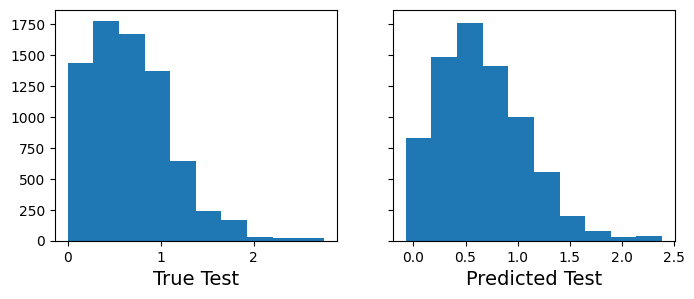

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(8,3), sharey=True)
ax[0].hist(y_test)
ax[0].set_xlabel('True Test', fontsize=14)
ax[1].hist(Y_pred_test)
ax[1].set_xlabel('Predicted Test', fontsize=14)


In [9]:
def predict_for_zeolite_373(_P_, normalized_features):
    
    P = _P_/P_TRAIN_STD
    
    density = normalized_features[0]; spg = normalized_features[1]; volume = normalized_features[2];
    pld = normalized_features[3]; lcd = normalized_features[4]; void_frac = normalized_features[5];
    surf_area_m2g = normalized_features[6]; surf_area_m2cm3 = normalized_features[7];
    ASA = normalized_features[8]; AV = normalized_features[9]; NASA = normalized_features[10];
    NAV = normalized_features[11]; VolFrac = normalized_features[12];
    largest_free_sphere = normalized_features[13]; largest_included_sphere = normalized_features[14]
    largest_included_sphere_free = normalized_features[15]

    f1 = (((1/((density)**2)/1) * P / (1 + (1/((density)**2)/1) * P)) - 0.34510445568068854)/0.15844603241860306; beta1 = 0.07337148018041849
    f2 = (((1*1*((void_frac)**2)) * P / (1 + (1*1*((void_frac)**2)) * P)) - 0.13402139615626685)/0.09807949467217342; beta2 = 1430198749526.224
    f3 = (((((VolFrac)**2)*1*(volume)) * P / (1 + (((VolFrac)**2)*1*(volume)) * P)) - 0.2099562104652133)/0.2192665701701981; beta3 = -0.2230577953955047
    f4 = (((((void_frac)**2)*1*1) * P / (1 + (((void_frac)**2)*1*1) * P)) - 0.13402139615626685)/0.09807949467217342; beta4 = -1430198749525.754
    f5 = ((((ASA)*1*((VolFrac)**2)) * P / (1 + ((ASA)*1*((VolFrac)**2)) * P)) - 0.43892114771426277)/0.43306015276923676; beta5 = 0.0414632001791709
    f6 = ((((NASA)*(largest_included_sphere)/((volume)**2)) * P / (1 + ((NASA)*(largest_included_sphere)/((volume)**2)) * P)) - 0.3362313626509776)/0.387612317674983; beta6 = 0.043098439630175324
    intercept = 0
    theta = beta1*f1 + beta2*f2 + beta3*f3 + beta4*f4 + beta5*f5 + beta6*f6
    loading_at_zero_P = -beta1*0.34510445568068854/0.158446032418603061 + -beta2*0.13402139615626685/0.098079494672173422 + -beta3*0.2099562104652133/0.21926657017019813 + -beta4*0.13402139615626685/0.098079494672173424 + -beta5*0.43892114771426277/0.433060152769236765 + -beta6*0.3362313626509776/0.3876123176749836
    epsilon_max = 1

    d = np.abs(P - 0)

    alpha = 2

    yt = theta + intercept + np.mean(y_train) + np.abs(loading_at_zero_P + np.mean(y_train))* epsilon_max * np.exp(-alpha * d)
    return yt


# Specific adsorbent

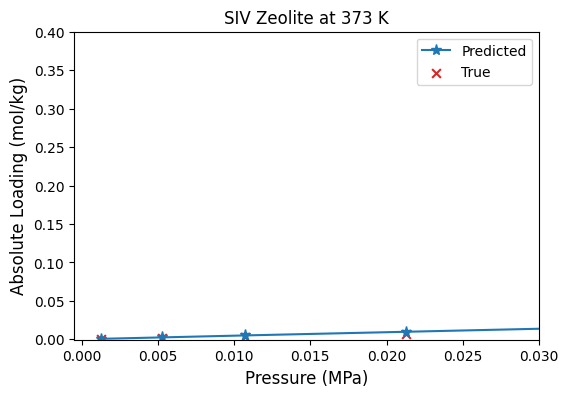

In [10]:
_specific_adsorbent_ = 'SIV'
plt.figure(figsize=(6,4), dpi=100)

CO2_OG_LOC_STR = r"/Users/arijitchakraborty/Library/CloudStorage/GoogleDrive-ac4758@columbia.edu/My Drive/Research/7_Zeolite_wTAMU_CES/Data/" + _ADSORBATE_ + ".xlsx"
CO2_temp_adsorbent_data = pd.read_excel(CO2_OG_LOC_STR, sheet_name=_specific_adsorbent_)

_specific_pressures_ = np.array([p for p in CO2_temp_adsorbent_data[CO2_temp_adsorbent_data[
                                'Temperature (K)']==373]['Pressure (Pa)']])
predictions = [predict_for_zeolite_373(p, list(_DATA_REINDEXED.loc[_specific_adsorbent_])) for p in _specific_pressures_]

plt.plot(_specific_pressures_/1e6, predictions, label='Predicted', c='tab:blue', marker='*', markersize=8)

plt.scatter(CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==373]['Pressure (Pa)']/1e6,
           CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==373]['Absolute Loading (mol/kg)'],
                   c='tab:red', label='True', marker='x', s=40)

plt.ylabel('Absolute Loading (mol/kg)', fontsize=12)
plt.xlabel('Pressure (MPa)', fontsize=12)

plt.title(r'{:s} Zeolite at 373 K'.format(_specific_adsorbent_))

plt.ylim(-0.0005, 0.4)
plt.xlim(-0.0005, 0.03)
plt.legend()
# plt.savefig('{}_373K.png'.format(_test_z_), dpi=150)
plt.show()


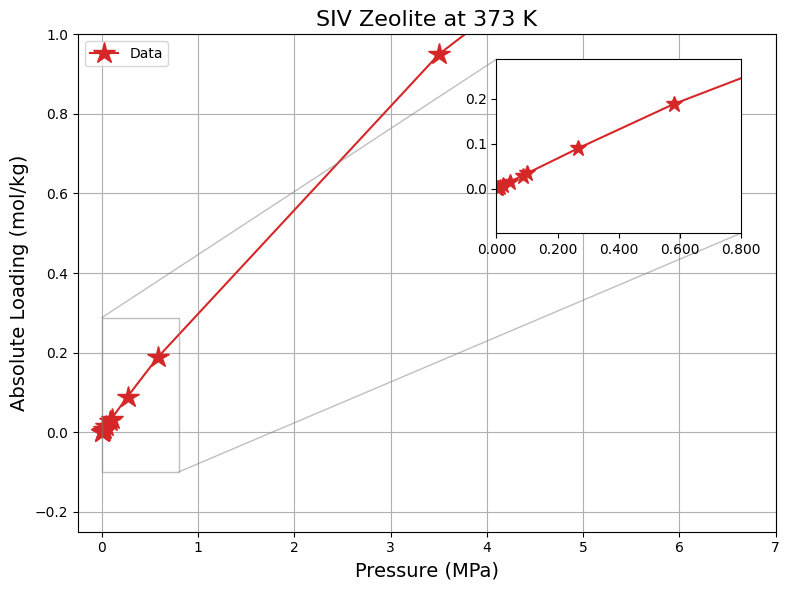

In [11]:
x = CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==373]['Pressure (Pa)']/1e6
y = CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==373]['Absolute Loading (mol/kg)']

# Assuming x and y are your numpy arrays
# Create main figure and plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, label='Data', c='tab:red', marker='*', markersize=16)
ax.set_xlabel('Pressure (MPa)', fontsize=14)
ax.set_ylabel('Absolute Loading (mol/kg)', fontsize=14)
ax.set_title(r'{:s} Zeolite at 373 K'.format(_specific_adsorbent_), fontsize=16)
ax.set_xlim(-0.25, 7)  # Set main plot x range
ax.set_ylim(-0.25, 1)
ax.grid(True)

# Create inset axes
axins = ax.inset_axes([0.6, 0.6, 0.35, 0.35])

# Plot zoomed region
axins.plot(x, y, label='Data', c='tab:red', marker='*', markersize=12)
axins.set_xlim(0, 0.8)  # Zoom in to very small x range
# Get y values in the zoomed region
mask = (x >= 0) & (x <= 0.8)
y_zoom = y[mask]
axins.set_ylim(min(y_zoom) - 0.1, max(y_zoom) + 0.1)
axins.grid(False)

# Add small tick marks for the zoomed region
axins.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))

# Draw box showing zoom area
ax.indicate_inset_zoom(axins)

plt.legend()
plt.tight_layout()
plt.show()

/var/folders/s6/wmy07hwx6j5fzckbkn3pv9540000gn/T/ipykernel_79066/2192361723.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6,4), dpi=100)


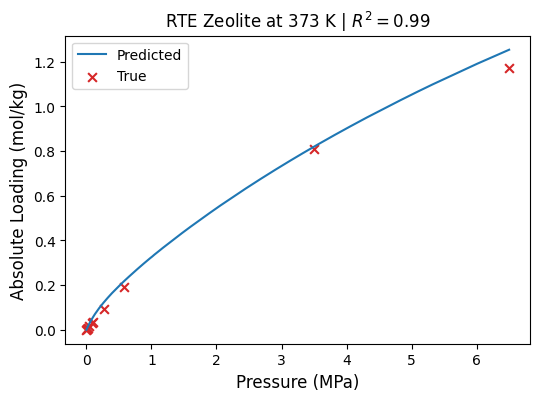

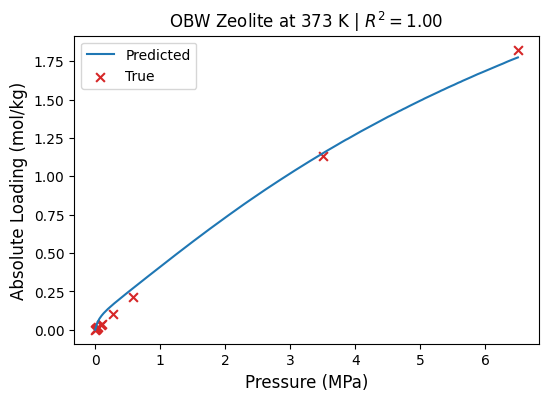

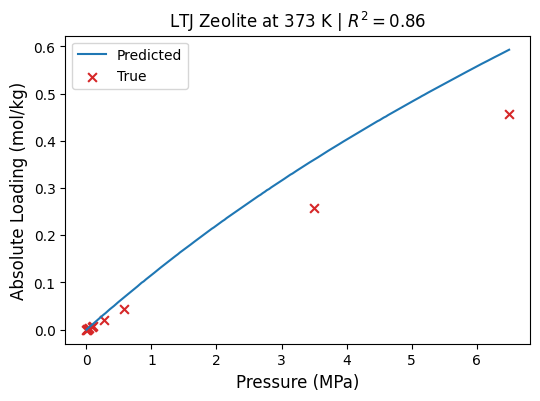

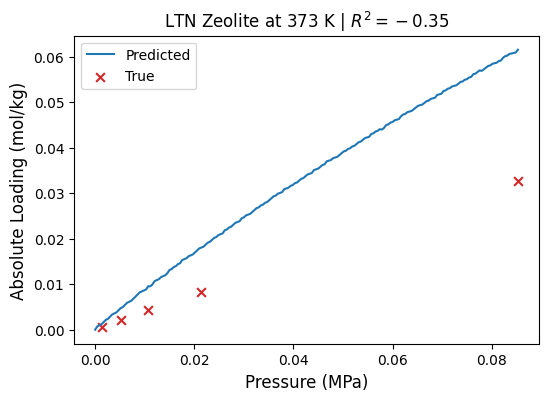

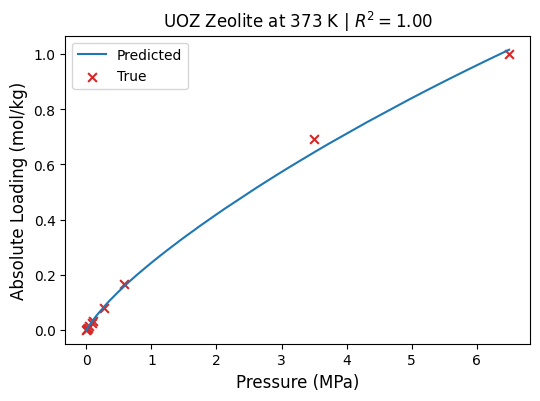

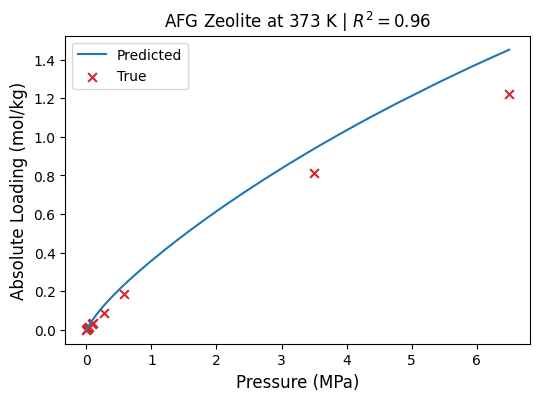

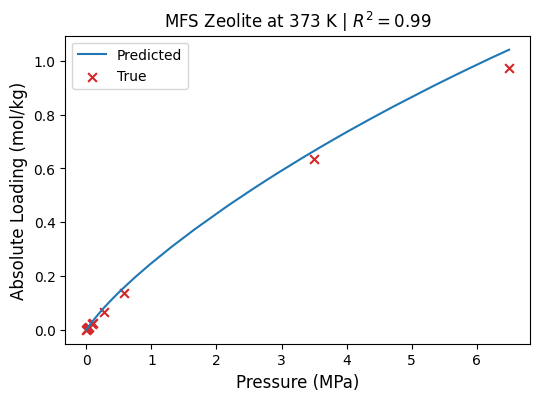

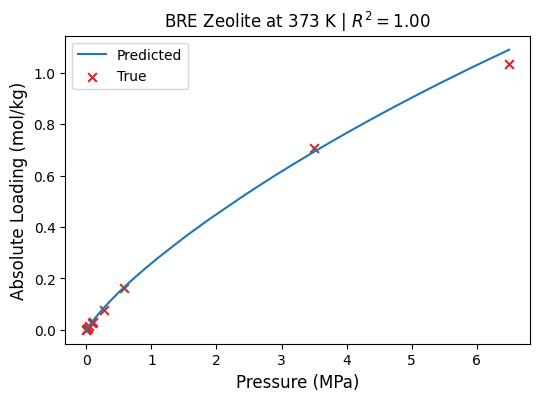

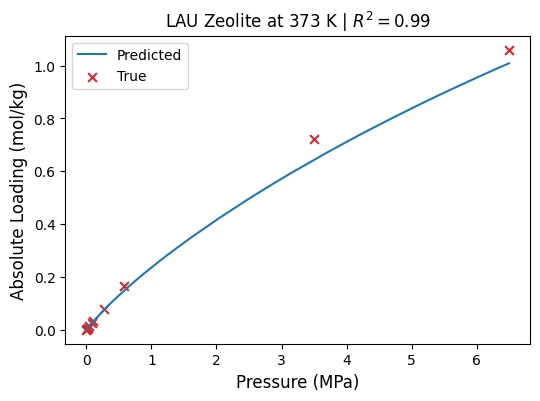

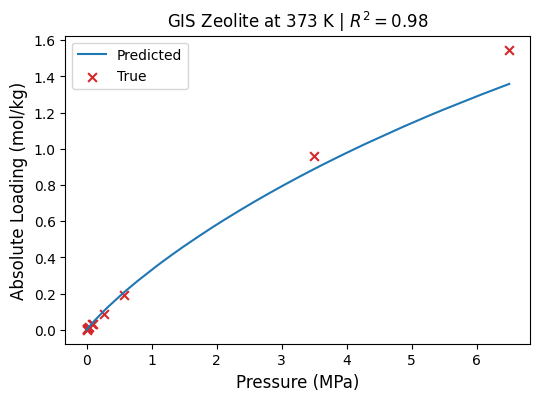

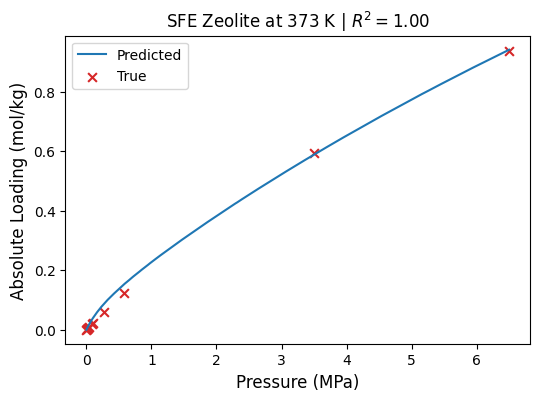

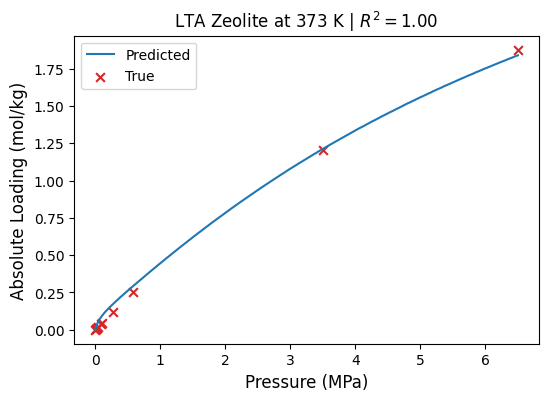

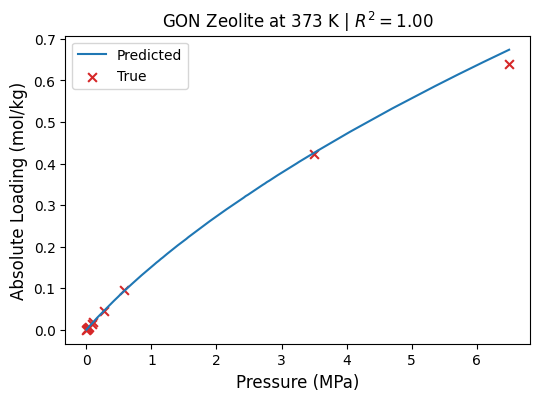

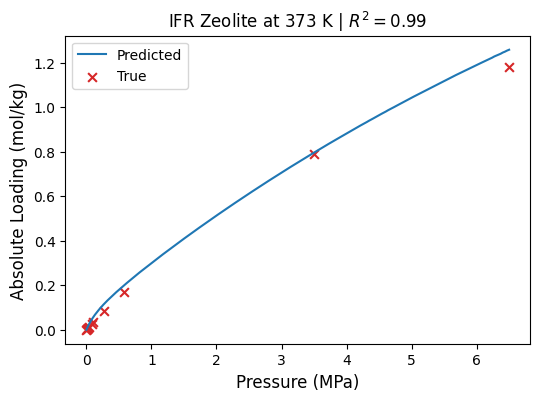

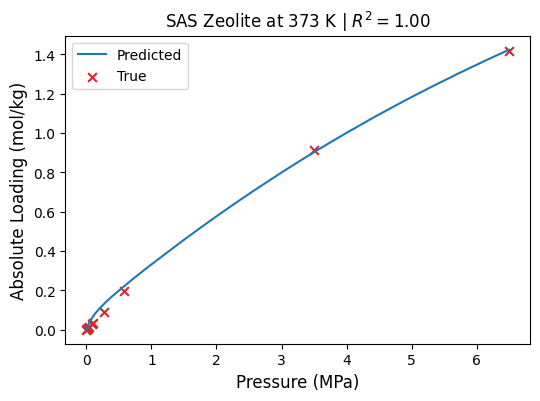

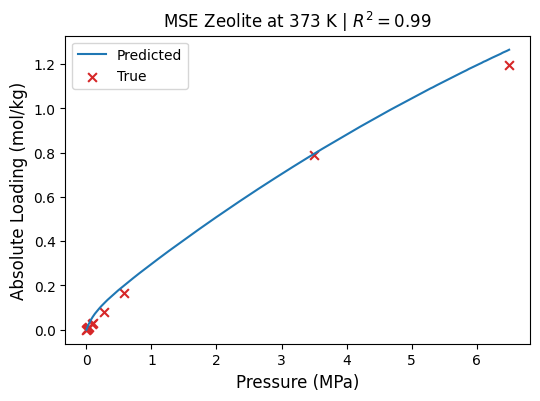

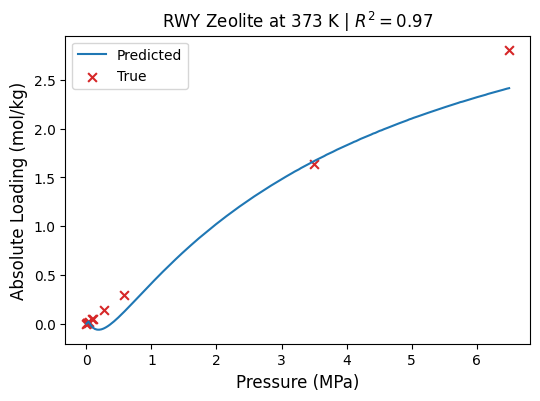

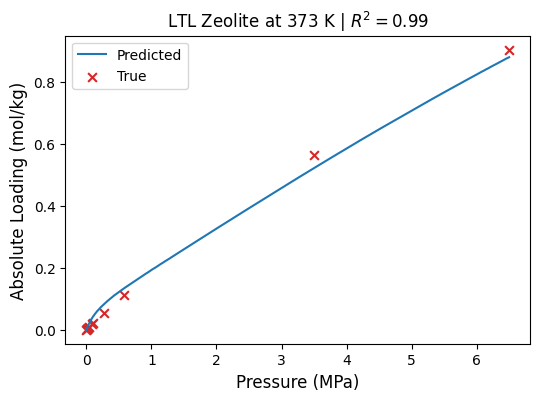

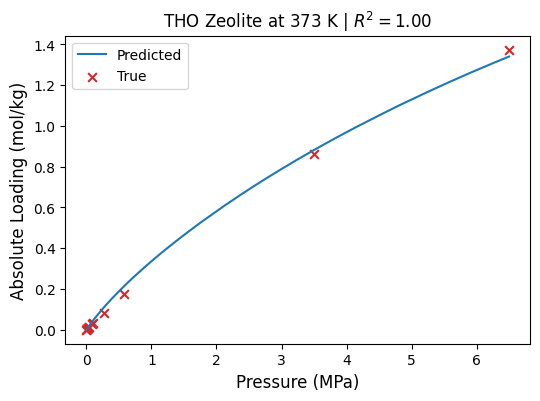

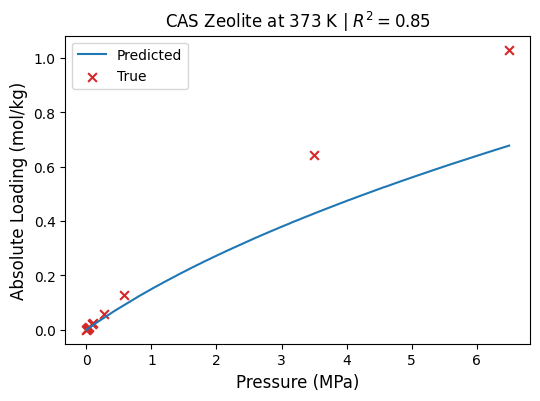

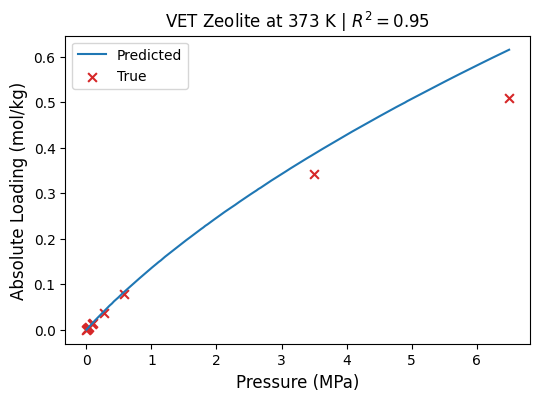

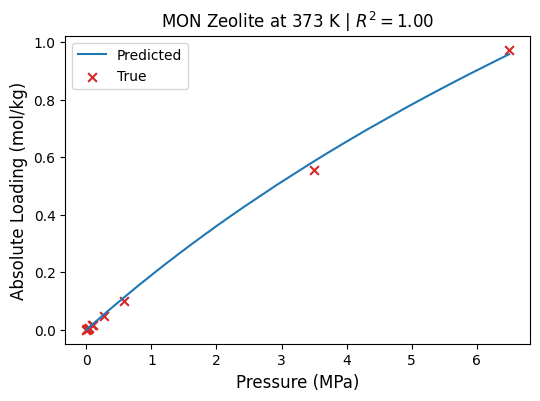

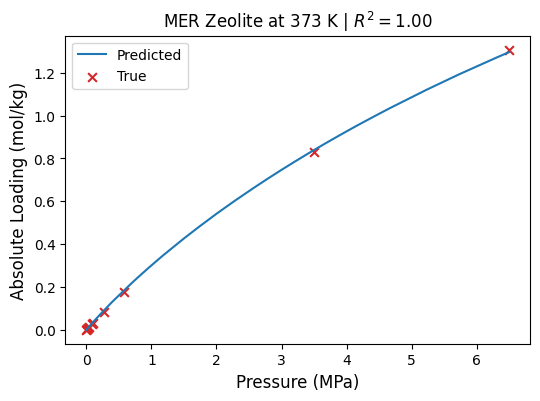

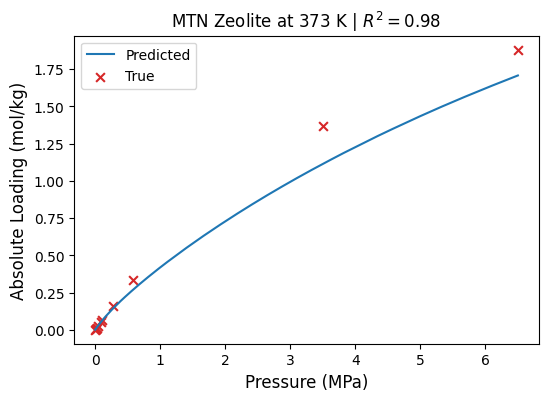

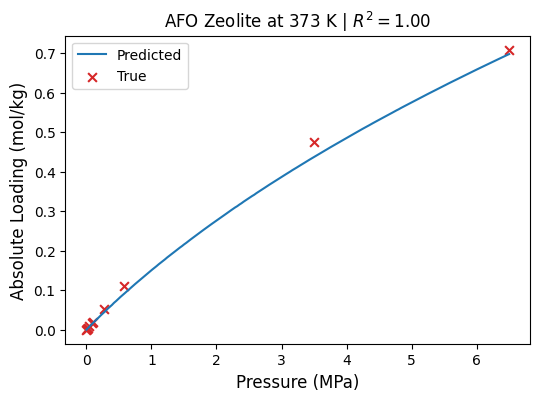

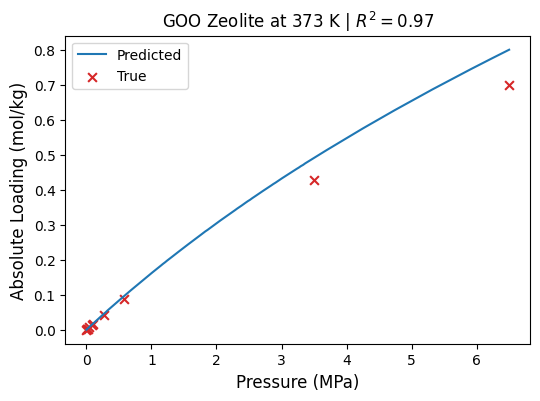

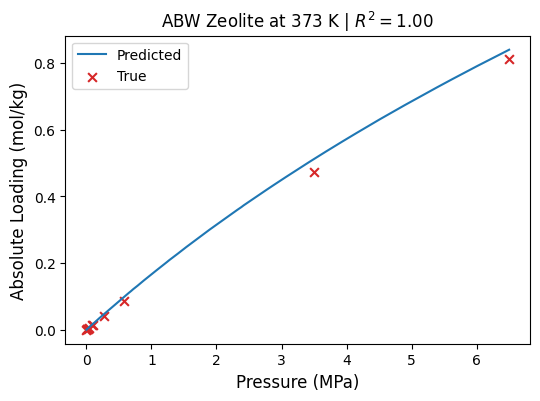

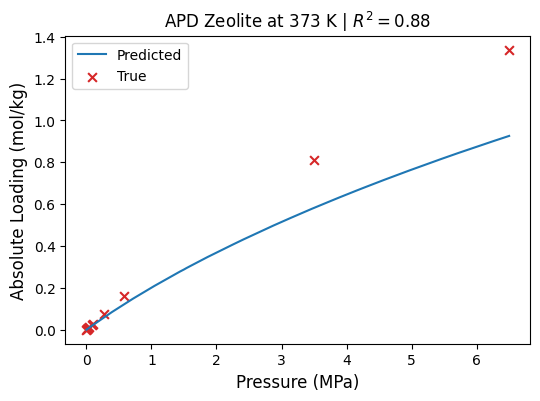

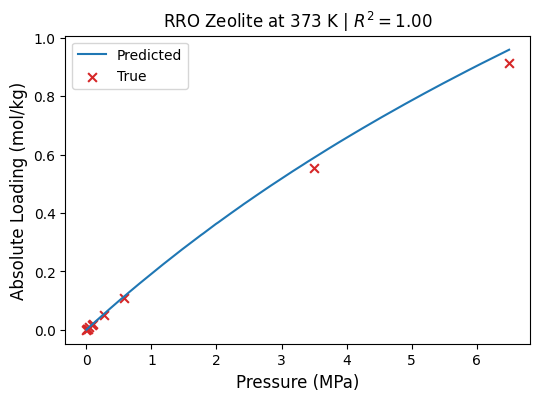

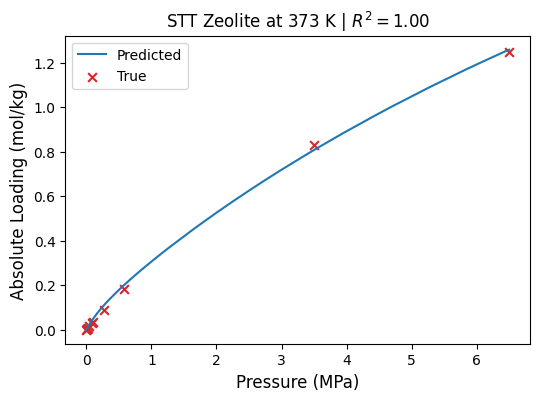

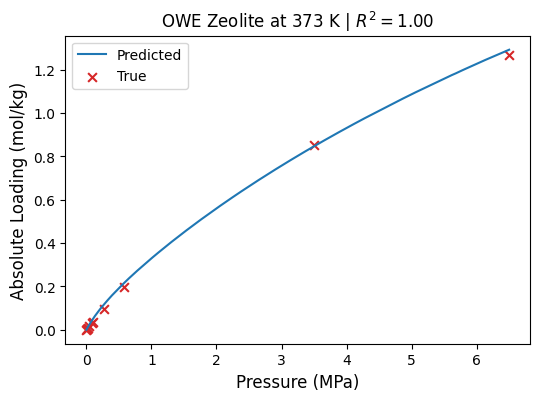

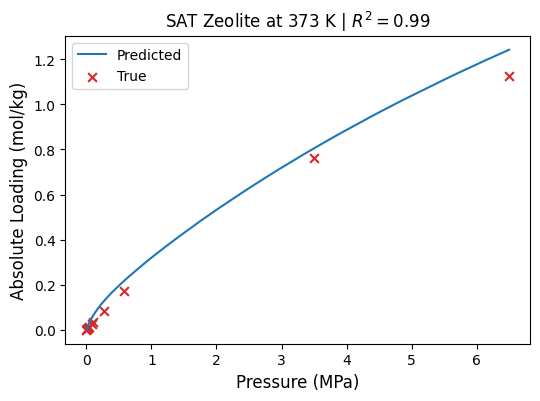

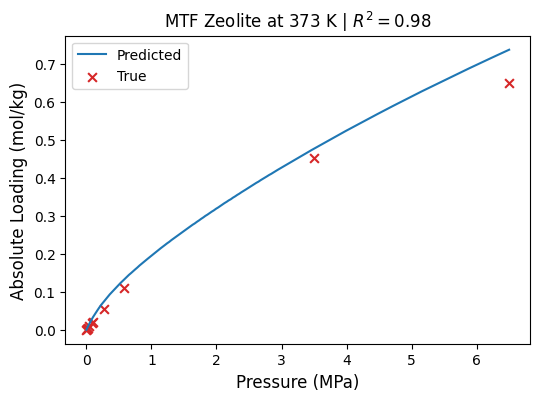

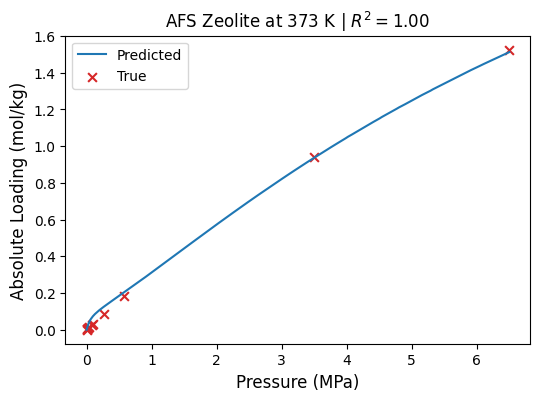

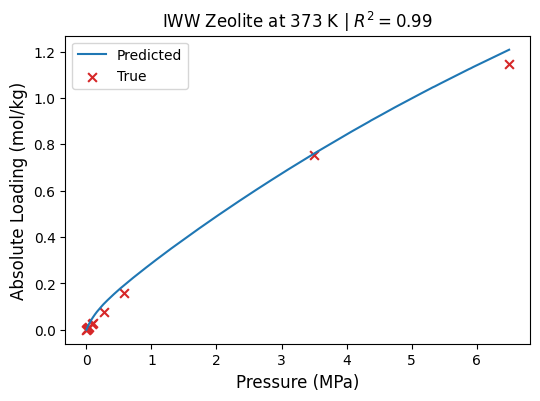

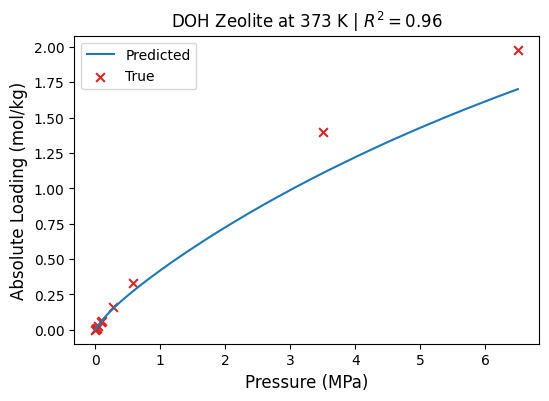

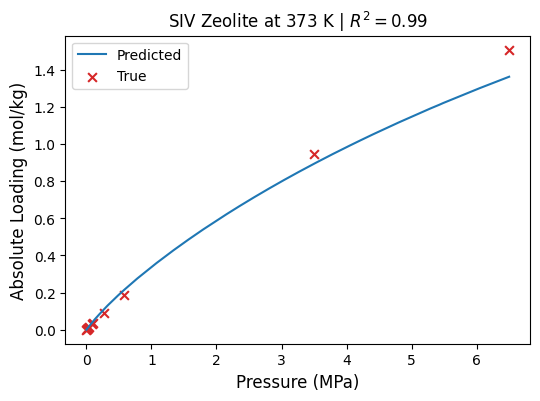

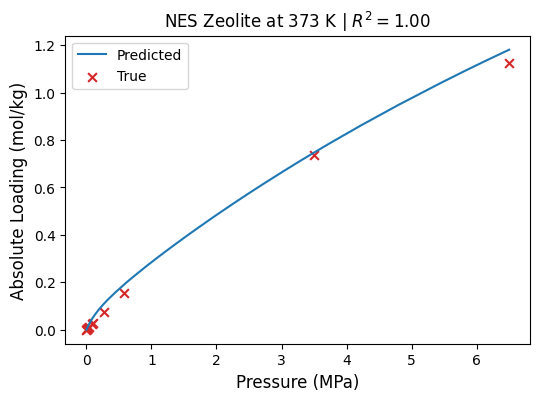

In [12]:
_373_real_ = []
_373_pred_ = []

for _test_z_ in TEST_ADSORBENTS:
# for _test_z_ in ['RWY']:
    
    try:
        plt.figure(figsize=(6,4), dpi=100)

        CO2_OG_LOC_STR = r"/Users/arijitchakraborty/Library/CloudStorage/GoogleDrive-ac4758@columbia.edu/My Drive/Research/7_Zeolite_wTAMU_CES/Data/" + _ADSORBATE_ + ".xlsx"
        CO2_temp_adsorbent_data = pd.read_excel(CO2_OG_LOC_STR, sheet_name=_test_z_)

#         _low_pressures_ = np.array([p for p in CO2_temp_adsorbent_data[CO2_temp_adsorbent_data[
#                                         'Temperature (K)']==373]['Pressure (Pa)'] if p<1e6])

        _specific_pressures_ = np.array([p for p in CO2_temp_adsorbent_data[CO2_temp_adsorbent_data[
                                        'Temperature (K)']==373]['Pressure (Pa)']])
        _specific_predictions_ = [predict_for_zeolite_373(p, list(_DATA_REINDEXED.loc[_test_z_])) for p in _specific_pressures_]

        min_p = min(CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==373]['Pressure (Pa)'])
        max_p = max(CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==373]['Pressure (Pa)'])
        p_range = np.linspace(0, max_p, 200)
        predictions = [predict_for_zeolite_373(p, list(_DATA_REINDEXED.loc[_test_z_])) for p in p_range]

#         predictions = [predict_for_zeolite_373(p, list(_DATA_REINDEXED.loc[_test_z_])) for p in _low_pressures_]
#         plt.plot(np.array([p for p in CO2_temp_adsorbent_data[
#                 CO2_temp_adsorbent_data['Temperature (K)']==373][
#                                 'Pressure (Pa)'] if p<1e6])/1e6, predictions,
#                          label='Predicted', c='tab:blue', marker='*', markersize=8)

        plt.plot(p_range/1e6, predictions, label='Predicted', c='tab:blue')

        plt.scatter(CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==373]['Pressure (Pa)']/1e6,
                   CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==373]['Absolute Loading (mol/kg)'],
                           c='tab:red', label='True', marker='x', s=40)

        plt.ylabel('Absolute Loading (mol/kg)', fontsize=12)
        plt.xlabel('Pressure (MPa)', fontsize=12)

        plt.title(r'{:s} Zeolite at 373 K | $R^{:d}={:.2f}$'.format(_test_z_,2, r2_score(
                    CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==373][
                        'Absolute Loading (mol/kg)'], [predict_for_zeolite_373(p, list(
                            _DATA_REINDEXED.loc[_test_z_])) for p in CO2_temp_adsorbent_data[
                                CO2_temp_adsorbent_data['Temperature (K)']==373]['Pressure (Pa)']])))

        _a_ = CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==373]
#         _373_pred_.append(predictions)
        _373_pred_.append(_specific_predictions_)
        _373_real_.append(_a_['Absolute Loading (mol/kg)'].tolist())
#         _373_real_.append(_a_[_a_['Pressure (Pa)']<1e6]['Absolute Loading (mol/kg)'].tolist())

#         plt.title(r'{:s} Zeolite at 373 K | $R^{:d}={:.2f}$'.format(_test_z_,2, r2_score(
#             _a_[_a_['Pressure (Pa)']<1e6]['Absolute Loading (mol/kg)'], [predict_for_zeolite_373(p, list(
#                             _DATA_REINDEXED.loc[_test_z_])) for p in _low_pressures_])))
#         plt.ylim(-0.15, 1)
#         plt.xlim(-0.15, 1)
        plt.legend()
#         plt.savefig('TRAIN_{}_373K.png'.format(_test_z_), dpi=150)
#         plt.show()
    except Exception as e:
        print(_test_z_, e)


In [13]:
def flatten_concatenation(matrix):
    flat_list = []
    for row in matrix:
        flat_list += row
    return flat_list

_373_preds = np.array(flatten_concatenation(_373_pred_))
_373_real = np.array(flatten_concatenation(_373_real_))

new_test_real = np.delete(_373_real, np.argwhere(np.isnan(_373_real)))
new_test_preds = np.delete(_373_preds, np.argwhere(np.isnan(_373_real)))
new_new_test_real = np.delete(new_test_real, np.argwhere(np.isnan(new_test_preds)))
new_new_test_preds = np.delete(new_test_preds, np.argwhere(np.isnan(new_test_preds)))


In [14]:
print(r2_score(new_new_test_real, new_new_test_preds))
print(mean_absolute_error(new_new_test_real, new_new_test_preds))


0.9820482942797777
0.023459100140975728
